In [28]:
import numpy as np
from numpy.linalg import eig
from scipy.optimize import fsolve
from scipy.optimize import fmin
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Yield to Maturity

## Part 1: Obtain Bond Data

### Part 1.1: Government of Canada

In [29]:
# load in dataset
dfBondInfo = pd.read_csv('/content/drive/My Drive/APM466/Assignment 1/Bond Information.csv')
lstBonds = ['CA135087L518', 'CA135087E679', 'CA135087F825', 'CA135087H235', 'CA135087J397',
            'CA135087L443', 'CA135087M276', 'CA135087N597', 'CA135087XG49']
dfBondInfo10 = dfBondInfo[dfBondInfo['ISIN'].isin(lstBonds)].set_index('ISIN')

# organize bond info into a dictionary
dictBondInfo10 = {}
date_format = '%m/%d/%Y'
for i in range(len(lstBonds)):
  bond = lstBonds[i]
  bondInfo = dfBondInfo10.loc[bond]
  coupon = bondInfo['Coupon']
  dtIssue = datetime.strptime(bondInfo['Issue Date'], date_format).date()
  dtMaturity = datetime.strptime(bondInfo['Maturity Date'], date_format).date()
  dictBondInfo10[bond] = {'Coupon': coupon, 'Issue Date': dtIssue, 'Maturity Date': dtMaturity}

# record price data for the 10 bonds on April 15th
strCurrent = '2024-04-15'
dtCurrent = datetime(2024, 4, 15).date()
lstPrices = [92.89, 94.61, 91.7, 93.22, 93.41,
             81.34, 86.12, 87.84, 114.98]
for i in range(len(lstBonds)):
  dictBondInfo10[lstBonds[i]]['Current Date'] = dtCurrent
  dictBondInfo10[lstBonds[i]]['Price'] = lstPrices[i]


### Part 1.2: Bell Canada

In [30]:
# load in dataset
dfBellInfo = pd.read_csv('/content/drive/My Drive/APM466/Assignment 2/Bell Canada Bond Data.csv').set_index('ISIN')

# organize bond info into a dictionary
dictBellInfo10 = dict()
date_format = '%m/%d/%Y'
lstBellBonds = list(dfBellInfo.index)
for bond in lstBellBonds:
  bondInfo = dfBellInfo.loc[bond]
  coupon = bondInfo['Coupon']
  dtMaturity = datetime.strptime(bondInfo['Maturity Date'], date_format).date()
  dictBellInfo10[bond] = {'Coupon': coupon, 'Issue Date': dtIssue, 'Maturity Date': dtMaturity, 'Price': bondInfo['Price']}


## Part 2: Calculate Dirty Price

In [31]:
# helper functions
def calc_dirty_price(dtCurrent, dtNextCoupon, fltCleanPrice, fltCoupon, FV=100):
  dtPreviousCoupon = dtNextCoupon - relativedelta(months=6)
  n = (dtCurrent-dtPreviousCoupon).days # number of days since the last payment
  fltDirtyPrice = fltCleanPrice + (n/365)*fltCoupon*FV
  return fltDirtyPrice


def find_next_coupon_date(dtCurrent, dtMaturity, return_list=False):
  lstCouponDates = []
  dtCoupon = dtMaturity
  while dtCoupon >= dtCurrent:
    lstCouponDates.append(dtCoupon)
    dtCoupon = dtCoupon - relativedelta(months=6)

  lstCouponDates = lstCouponDates[::-1] # sort coupon payment dates from smallest to largest
  if return_list is True:
    return lstCouponDates
  else:
    return lstCouponDates[0]

### Part 2.1: Government of Canada

In [32]:
dfBondDirtyPrice10 = pd.DataFrame(index=lstBonds, columns=[strCurrent])
fltFaceValue = 100

for bond in dfBondDirtyPrice10.index:
  fltCleanPrice = dictBondInfo10[bond]['Price']
  fltCoupon = dictBondInfo10[bond]['Coupon']
  dtMaturity = dictBondInfo10[bond]['Maturity Date']
  dtNextCoupon = find_next_coupon_date(dtCurrent, dtMaturity)
  fltDirtyPrice = calc_dirty_price(dtCurrent, dtNextCoupon, fltCleanPrice, fltCoupon, fltFaceValue)
  dfBondDirtyPrice10.loc[bond] = fltDirtyPrice

dfBondDirtyPrice10

,2024-04-15
CA135087L518,92.920822
CA135087E679,95.168904
CA135087F825,92.072603
CA135087H235,93.965205
CA135087J397,94.248356
CA135087L443,81.526301
CA135087M276,86.678904
CA135087N597,88.585205
CA135087XG49,117.122466


### Part 2.2: Bell Canada

In [33]:
dfBellDirtyPrice10 = pd.DataFrame(index=lstBellBonds, columns=[strCurrent])
fltFaceValue = 100

for bond in dfBellDirtyPrice10.index:
  fltCleanPrice = dictBellInfo10[bond]['Price']
  fltCoupon = dictBellInfo10[bond]['Coupon']
  dtMaturity = dictBellInfo10[bond]['Maturity Date']
  dtNextCoupon = find_next_coupon_date(dtCurrent, dtMaturity)
  fltDirtyPrice = calc_dirty_price(dtCurrent, dtNextCoupon, fltCleanPrice, fltCoupon, fltFaceValue)
  dfBellDirtyPrice10.loc[bond] = fltDirtyPrice

dfBellDirtyPrice10

,2024-04-15
CA078149DT53,110.841027
CA078149DW82,106.011918
CA07813ZCL63,98.77274
CA07813ZAL81,114.159589
CA078149DV00,114.682603
CA07813ZAP95,112.28
CA078149DK45,130.952192
CA07813ZAT18,106.25137


## Part 3: YTM Calculation

In [34]:
# helper functions
def convert_years(dtCurrent, dtCoupon):
  n_days = (dtCoupon - dtCurrent).days
  n_yrs = n_days / 365
  return n_yrs


def convert_days(dtCurrent, dtCoupon):
  n_days = (dtCoupon - dtCurrent).days
  return n_days


def findYTM(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears):
  fltGuess = fltCoupon
  npCF = np.array(lstCashFlows)
  npYrs = np.array(lstYears)

  def equation(r):
    npDiscount = np.exp(-r*npYrs) # exp(-rT)
    PV = np.sum(npCF*npDiscount)
    return PV - fltDirtyPrice

  solution = fsolve(equation, fltGuess)
  return solution[0]


def calc_YTM(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, FV):
  lstCouponDates = find_next_coupon_date(dtCurrent, dtMaturity, return_list=True)
  lstYears = [convert_years(dtCurrent, dtCoupon) for dtCoupon in lstCouponDates]
  lstCashFlows = [(fltCoupon*FV/2) for _ in range(len(lstYears))]
  lstCashFlows[-1] += FV
  fltYTM = findYTM(fltDirtyPrice, fltCoupon, FV, lstCashFlows, lstYears)
  return fltYTM


### Part 3.1: Government of Cananda

In [35]:
dfBondYTM10 = pd.DataFrame(index=lstBonds, columns=[strCurrent])
fltFV = 100
for bond in dfBondYTM10.index:
  fltCoupon = dictBondInfo10[bond]['Coupon']
  dtMaturity = dictBondInfo10[bond]['Maturity Date']
  fltDirtyPrice = dfBondDirtyPrice10.loc[bond][strCurrent]
  fltYTM = calc_YTM(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, fltFV)
  dfBondYTM10.loc[bond] = fltYTM
dfBondYTM10

,2024-04-15
CA135087L518,0.041866
CA135087E679,0.041277
CA135087F825,0.038035
CA135087H235,0.037503
CA135087J397,0.036351
CA135087L443,0.036639
CA135087M276,0.036993
CA135087N597,0.037115
CA135087XG49,0.037539


### Part 3.2: Bell Cananda

In [36]:
dfBellYTM = pd.DataFrame(index=lstBellBonds, columns=[strCurrent])
fltFV = 100
for bond in dfBellYTM.index:
  fltCoupon = dictBellInfo10[bond]['Coupon']
  dtMaturity = dictBellInfo10[bond]['Maturity Date']
  fltDirtyPrice = dfBellDirtyPrice10.loc[bond][strCurrent]
  fltYTM = calc_YTM(dtCurrent, dtMaturity, fltDirtyPrice, fltCoupon, fltFV)
  dfBellYTM.loc[bond] = fltYTM
dfBellYTM

,2024-04-15
CA078149DT53,0.053625
CA078149DW82,0.051299
CA07813ZCL63,0.048938
CA07813ZAL81,0.053546
CA078149DV00,0.055535
CA07813ZAP95,0.05438
CA078149DK45,0.055329
CA07813ZAT18,0.053208


## Part 4: Yield Curve Interpolation

In [37]:
# helper functions

# get bond maturity information
def get_maturity_info(lstSelectedBonds, lstCurrentDates, dictBondInfo):
  dfBondMaturity = pd.DataFrame(index=lstSelectedBonds, columns=lstCurrentDates)
  for bond in dfBondMaturity.index:
    dtMaturity = dictBondInfo[bond]['Maturity Date']
    lstMaturity = []
    for i in range(len(lstCurrentDates)):
      dtCurrent = datetime.strptime(lstCurrentDates[i], '%Y-%m-%d').date()
      n_yrs = convert_years(dtCurrent, dtMaturity)
      lstMaturity.append(n_yrs)
    dfBondMaturity.loc[bond] = lstMaturity
  return dfBondMaturity

# interpolate curve
def interpolate_curve(dfData, lstYears, lstCurrentDates, dictInterpolate, dfBondMaturity):
  dfInterpolate = pd.DataFrame(index=lstYears, columns=lstCurrentDates)
  for strCurrent in lstCurrentDates:
      dtCurrent = datetime.strptime(strCurrent, '%Y-%m-%d').date()
      npMaturity = np.array(dfBondMaturity[strCurrent])
      npRate = np.array(dfData[strCurrent])
      lstRate = []
      n_yrs = 1
      for key, items in dictInterpolate.items():
        fltRate1, fltRate2 = npRate[items[0]], npRate[items[1]]
        fltDate1, fltDate2 = npMaturity[items[0]], npMaturity[items[1]]
        fltRate = fltRate1 * ((fltDate2-n_yrs)/(fltDate2-fltDate1)) + fltRate2 * ((n_yrs-fltDate1)/(fltDate2-fltDate1))
        lstRate.append(fltRate)
        n_yrs += 1
      dfInterpolate[strCurrent] = lstRate
  return dfInterpolate


### Part 4.1: Government of Cananda

In [38]:
# YTM Interpolation
# get bond maturity information
dfBondMaturity10 = get_maturity_info(lstBonds, [strCurrent], dictBondInfo10)
# interpolate YTM curve
lstYears = ['Year 2', 'Year 3', 'Year 4', 'Year 5', 'Year 6', 'Year 7', 'Year 8', 'Year 9']
dictInterpolate = {'Year 2': (0, 1), 'Year 3': (1, 2), 'Year 4': (2, 3), 'Year 5': (3, 4),
                   'Year 6': (4, 5), 'Year 7': (5, 6), 'Year 8': (6, 7), 'Year 9': (7, 8)}
dfYTMInterpolate = interpolate_curve(dfBondYTM10, lstYears, [strCurrent], dictInterpolate, dfBondMaturity10)
dfYTMInterpolate

,2024-04-15
Year 2,0.043914
Year 3,0.041694
Year 4,0.038103
Year 5,0.037655
Year 6,0.036325
Year 7,0.036189
Year 8,0.036977
Year 9,0.037058


### Part 4.2: Bell Cananda

In [39]:
# YTM Interpolation
# get bond maturity information
dfBellMaturity10 = get_maturity_info(lstBellBonds, [strCurrent], dictBellInfo10)
# interpolate YTM curve
lstYears = ['Year 3', 'Year 4', 'Year 5', 'Year 6', 'Year 7', 'Year 8', 'Year 9']
dictInterpolate = {'Year 3': (0, 1), 'Year 4': (1, 2), 'Year 5': (1, 2),
                   'Year 6': (2, 3), 'Year 7': (3, 4), 'Year 8': (5, 6), 'Year 9': (6, 7)}
dfBellYTMInterpolate = interpolate_curve(dfBellYTM, lstYears, [strCurrent], dictInterpolate, dfBellMaturity10)
dfYear2 = pd.DataFrame([{'2024-04-15': 0.053625}], index=['Year 2'])
dfBellYTMInterpolate = pd.concat([dfYear2, dfBellYTMInterpolate])
dfBellYTMInterpolate

,2024-04-15
Year 2,0.053625
Year 3,0.055251
Year 4,0.052731
Year 5,0.051739
Year 6,0.041578
Year 7,0.048296
Year 8,0.052201
Year 9,0.056908


## Part 5: Plot the Interpolated YTM Curves

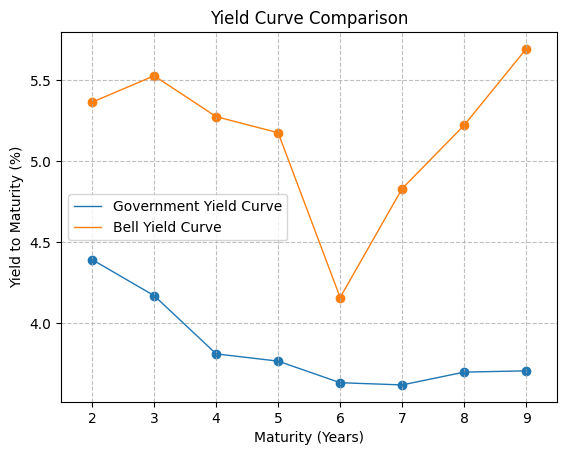

Credit Spread: 1.3051857956269823


In [51]:
lstYrs = [2, 3, 4, 5, 6, 7, 8, 9]

# plot Government of Canada YTM
npGovYTM = np.array(dfYTMInterpolate[strCurrent]) * 100
plt.plot(lstYrs, npGovYTM, label='Government Yield Curve', linewidth=1)
plt.scatter(lstYrs, npGovYTM)
# plot Bell Canada YTM
npBellYTM = np.array(dfBellYTMInterpolate[strCurrent]) * 100
plt.plot(lstYrs, npBellYTM, label='Bell Yield Curve', linewidth=1)
plt.scatter(lstYrs, npBellYTM)

plt.title('Yield Curve Comparison')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield to Maturity (%)')
plt.xlim(1.5, 9.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

print(f'Credit Spread: {np.mean(npBellYTM-npGovYTM)}')

In [41]:
dfBellYTM

,2024-04-15
CA078149DT53,0.053625
CA078149DW82,0.051299
CA07813ZCL63,0.048938
CA07813ZAL81,0.053546
CA078149DV00,0.055535
CA07813ZAP95,0.05438
CA078149DK45,0.055329
CA07813ZAT18,0.053208


# Merton Model

In [42]:
# obtain annualized stock price volatility
strStartDate, strEndDate = '2023-04-15', '2024-04-15'
strToken = 'BCE.TO'
dfPrice = yf.download(strToken, start=strStartDate, end=strEndDate)['Adj Close']
dfDailyReturns = dfPrice.pct_change().dropna()
sigma_S = np.std(np.array(dfDailyReturns)) * np.sqrt(252) # assume 252 trading days in a year

[*********************100%%**********************]  1 of 1 completed


In [52]:
# initialize parameters
S = 40.35 # market cap in billions
K = 36.18 # total debt in billions
T = 1 # assume 1-year horizon
r = 0.04
sigma_S = 0.14819383459570615 # from Yahoo Finance

In [53]:
# solve for implied asset volatility
def N(x):
    N = stats.norm.cdf(x, 0.0, 1.0)
    return N


def ImpliedMerton(c):
    d1 = np.log(c[0]/(K*np.exp(-r*T))) / (c[1]*np.sqrt(T)) + 0.5*c[1]*np.sqrt(T)
    d2 = d1 - c[1]*np.sqrt(T)
    f1 = (c[0]*N(d1) - K*np.exp(-r*T)*N(d2)) - S
    f2 = sigma_S*S - N(d1)*c[1]*c[0]
    val = f1**2 + f2**2
    #print("[V, σV]=",c,", Object Function Value:", val)
    return(val)


c = fmin(ImpliedMerton, [S+K, sigma_S]) # c[0]: V or asset value; c[1]: sigma_V
V, sigma_V = c[0], c[1]
print(f'\nAsset Value: {V} billion; Asset Volatility: {sigma_V}\n')
# calculate Distance to Default
DD = (V-K) / (V*sigma_V)
print(f'Distance to Default: {DD}\n')
# calculate default probability
DP = N(-DD)
print(f'Default Probability: {DP}\n')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 96

Asset Value: 75.11134637214491 billion; Asset Volatility: 0.07961096644421939

Distance to Default: 6.5105994982645505

Default Probability: 3.742573452097544e-11



In [45]:
# solve for implied asset volatility
def N(x):
    N = stats.norm.cdf(x, 0.0, 1.0)
    return N

def calc_DP(S, sigma_S, K, r, T):

  def ImpliedMerton(c):
    d1 = np.log(c[0]/(K*np.exp(-r*T))) / (c[1]*np.sqrt(T)) + 0.5*c[1]*np.sqrt(T)
    d2 = d1 - c[1]*np.sqrt(T)
    f1 = (c[0]*N(d1) - K*np.exp(-r*T)*N(d2)) - S
    f2 = sigma_S*S - N(d1)*c[1]*c[0]
    val = f1**2 + f2**2
    #print("[V, σV]=",c,", Object Function Value:", val)
    return(val)

  c = fmin(ImpliedMerton, [S+K, sigma_S]) # c[0]: V or asset value; c[1]: sigma_V
  V, sigma_V = c[0], c[1]
  DD = (V-K) / (V*sigma_V)
  DP = N(-DD)

  return DP

In [46]:
years= 50
lstDP_KVM = []
for t in range(1, years+1):
  DP = calc_DP(S, sigma_S, K, r, t)
  lstDP_KVM.append(DP)
lstDP_KVM

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 44
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 85
Optimization terminated successful

[4.991372181010989e-11,
 2.8307149032655137e-10,
 1.3879537597706755e-09,
 5.95987198715554e-09,
 2.2653006901024498e-08,
 7.710921306675044e-08,
 2.3737201180585828e-07,
 6.66554373846501e-07,
 1.7207513731129226e-06,
 4.1141654326850035e-06,
 9.172284260666273e-06,
 1.9179895733882443e-05,
 3.780921567230129e-05,
 7.062952404784366e-05,
 0.0001256284727431922,
 0.00021352587562824903,
 0.0003482165733902379,
 0.0005467094308711889,
 0.0008289771278794241,
 0.0012176594546189949,
 0.0017369429119025053,
 0.002411785041809158,
 0.0032674963420180263,
 0.004327755119292296,
 0.005614733759847583,
 0.007146620538600309,
 0.0089392128882164,
 0.011001943226811637,
 0.01334134918149379,
 0.015960252516770915,
 0.018855198766000704,
 0.02201667170151685,
 0.025438001982021743,
 0.029099529963512543,
 0.0329945478747077,
 0.03709238473349781,
 0.04137892698067903,
 0.04582923974098378,
 0.050422331240117156,
 0.05513643864176304,
 0.05995275662503781,
 0.06483928280527027,
 0.069781527405149

# CreditMetrics Model

In [47]:
dictRating = {'AAA': 0, 'AAA': 1, 'A': 2, 'BBB': 3, 'BB': 4,
              'B': 5, 'CCC': 6, 'D': 7}
Bell_rating = 'BBB'
Bell_index = dictRating[Bell_rating]
default_index = dictRating['D']
years= 50
transition_matrix = [
    [100.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 96.81, 1.42, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.15, 96.78, 1.02, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 1.61, 92.68, 0.97, 0.43, 0.11, 0.11],
    [0.00, 0.00, 0.17, 3.92, 85.67, 3.83, 0.25, 0.17],
    [0.00, 0.00, 0.00, 0.10, 4.24, 79.07, 5.84, 1.24],
    [0.00, 0.00, 0.00, 0.00, 0.00, 7.34, 47.40, 30.89],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 100.00]
]
transition_matrix = np.array(transition_matrix) / 100
lstDP_CM = []

for i in range(1, years+1):
  lstDP_CM.append(transition_matrix[Bell_index][default_index])
  transition_matrix = transition_matrix @ transition_matrix

lstDP_CM

[0.0011,
 0.0025290800000000004,
 0.0059255372853746005,
 0.013480946350530175,
 0.02743164965854525,
 0.044402294085503634,
 0.054482711751834764,
 0.05720021966562197,
 0.05760914555356362,
 0.05762339136175259,
 0.05762341110102618,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.05762341110106696,
 0.0576234111010

# Compare Default Probabilities of KVM and CreditMetrics

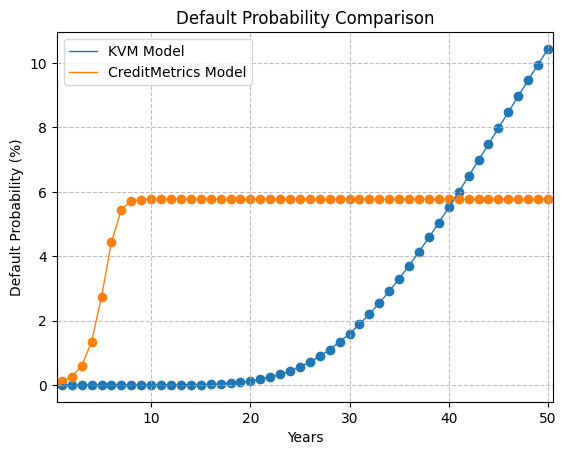

In [48]:
lstYrs = [yr for yr in range(1, years+1)]

# plot KVM Default Probability
npKVM = np.array(lstDP_KVM) * 100
plt.plot(lstYrs, npKVM, label='KVM Model', linewidth=1)
plt.scatter(lstYrs, npKVM)
# plot CreditMetrics Default Probability
npCM = np.array(lstDP_CM) * 100
plt.plot(lstYrs, npCM, label='CreditMetrics Model', linewidth=1)
plt.scatter(lstYrs, npCM)

plt.title('Default Probability Comparison')
plt.xlabel('Years')
plt.ylabel('Default Probability (%)')
plt.xlim(0.5, (years+0.5))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()